# Statistical Analysis 

In [170]:
#Imports
import pandas as pd
from sklearn.decomposition import IncrementalPCA
from matplotlib.pyplot import scatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import itertools
import pycountry_convert as pc
from scipy.stats import mannwhitneyu
from statistics import median
%matplotlib inline

In [137]:
path = '/home/karim/Downloads/Newmerged_data_2020.csv.gzip'  #Modify

In [138]:
df_quotes_chunks = pd.read_csv(path, chunksize = 40000, low_memory = False, compression='gzip')
samples = []
for i, chunk in enumerate(df_quotes_chunks):
    # get sample and append it to samples
    sample = chunk.sample(400)
    samples.append(sample)

In [139]:
sample = pd.concat(samples)
sample.drop_duplicates(inplace=True)
sample.reset_index()
sample.shape
sample.head(10)

,qid,Unnamed: 0_x,quoteID,quotation,speaker,prob,sentence_count,._per_sentence,",_per_sentence",!_per_sentence,...,union_ratio,other_ratio,sentiment,Unnamed: 0_y,date_of_birth,nationality,gender,occupation,academic_degree,religion
13461,Q10520,338971.0,2020-04-10-026605,"It's difficult times. You know, I think with I...",David Beckham,0.7417,3,1.0,1.0,0.0,...,0.0,-0.5,0.069,1990849,1975.0,United States of America,Male,Sports,NaN,Christian
18079,Q1058,611768.0,2020-01-15-059533,neech aadmi (a degenerate),Narendra Modi,0.8194,1,0.0,0.0,0.0,...,0.0,0.0,0.000,7,1950.0,India,Male,Politics,NaN,Hindus
3739,Q1018358,987486.0,2020-02-18-021961,He always knew how to put the carrot out in fr...,Buzz Schneider,0.5653,1,0.0,1.0,0.0,...,-1.0,1.0,0.000,1344926,1954.0,United States of America,Male,Sports,NaN,NaN
22203,Q1058,1878277.0,2020-02-01-053393,Under the leadership of Prime Minister Shri @n...,Narendra Modi,0.6197,1,1.0,1.0,0.0,...,0.0,0.0,0.000,7,1950.0,India,Male,Politics,NaN,Hindus
39272,Q1100710,1209357.0,2020-03-04-071945,"We are continuing to bolster testing capacity,",Jay Inslee,0.6807,1,0.0,1.0,0.0,...,1.0,-1.0,0.000,2341805,1951.0,United States of America,Male,Politics,NaN,Christian
11791,Q1044151,1411199.0,2020-01-18-023352,"It is a compelling case, but I am certain the ...",Carol Ann Lee,0.7798,1,1.0,1.0,0.0,...,-1.0,-1.0,0.022,681943,1969.0,United Kingdom,Female,Arts,NaN,NaN
8961,Q10305061,759892.0,2020-03-04-077565,we tried to get there in time,Jamie Cavanagh,0.6772,1,0.0,0.0,0.0,...,1.0,-1.0,0.000,1439878,2000.0,NaN,Male,Other,NaN,NaN
13049,Q105123,1582379.0,2020-01-08-011744,by promoting the comprehensive digitalization ...,Matthias Berninger,0.9200,1,0.0,1.0,0.0,...,0.0,0.0,0.474,998051,1971.0,Germany,Male,Politics,NaN,NaN
18911,Q1058,869543.0,2020-01-12-006946,Development of waterways has improved Kolkata ...,Narendra Modi,0.8180,1,1.0,3.0,0.0,...,0.0,0.0,0.197,7,1950.0,India,Male,Politics,NaN,Hindus
20286,Q1058,1293667.0,2020-03-23-053202,"Thank you Afghanistan, for contributing $1 Mil...",Narendra Modi,0.5191,2,1.0,0.5,0.0,...,-1.0,1.0,0.080,7,1950.0,India,Male,Politics,NaN,Hindus


In [140]:
selected_feats = ['approx_word_count', 'token_count', 'adj_per_word', 'verb_per_word', 'base_ratio', 'pres_ratio', 'past_ratio', 'pronoun_per_word', 'sentiment']
speaker_feats = ['date_of_birth', 'nationality', 'gender', 'occupation', 'academic_degree', 'religion']

In [141]:
def mean_boxplots(df,plot_by,features,order=None):
    """Plots the means of a given feature with respect to a given parameter.

    Keyword arguments:
    df -- dataframe to be analyzed
    plot_by -- list of parameters in string format to be compared
    features -- list of features in string format to be plotted
    """
    
    num = int(math.sqrt(len(features)))
    fig, axs = plt.subplots(num,num,figsize=(30, 15))
    for i,feat in enumerate(features):
        if i<num**2:
            x_idx = int(np.floor(i/num))
            y_idx = int(i%num)
            sns.boxplot(x=plot_by, y=feat, data=df, ax=axs[x_idx,y_idx], order=order,showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
        
    return

## Gender

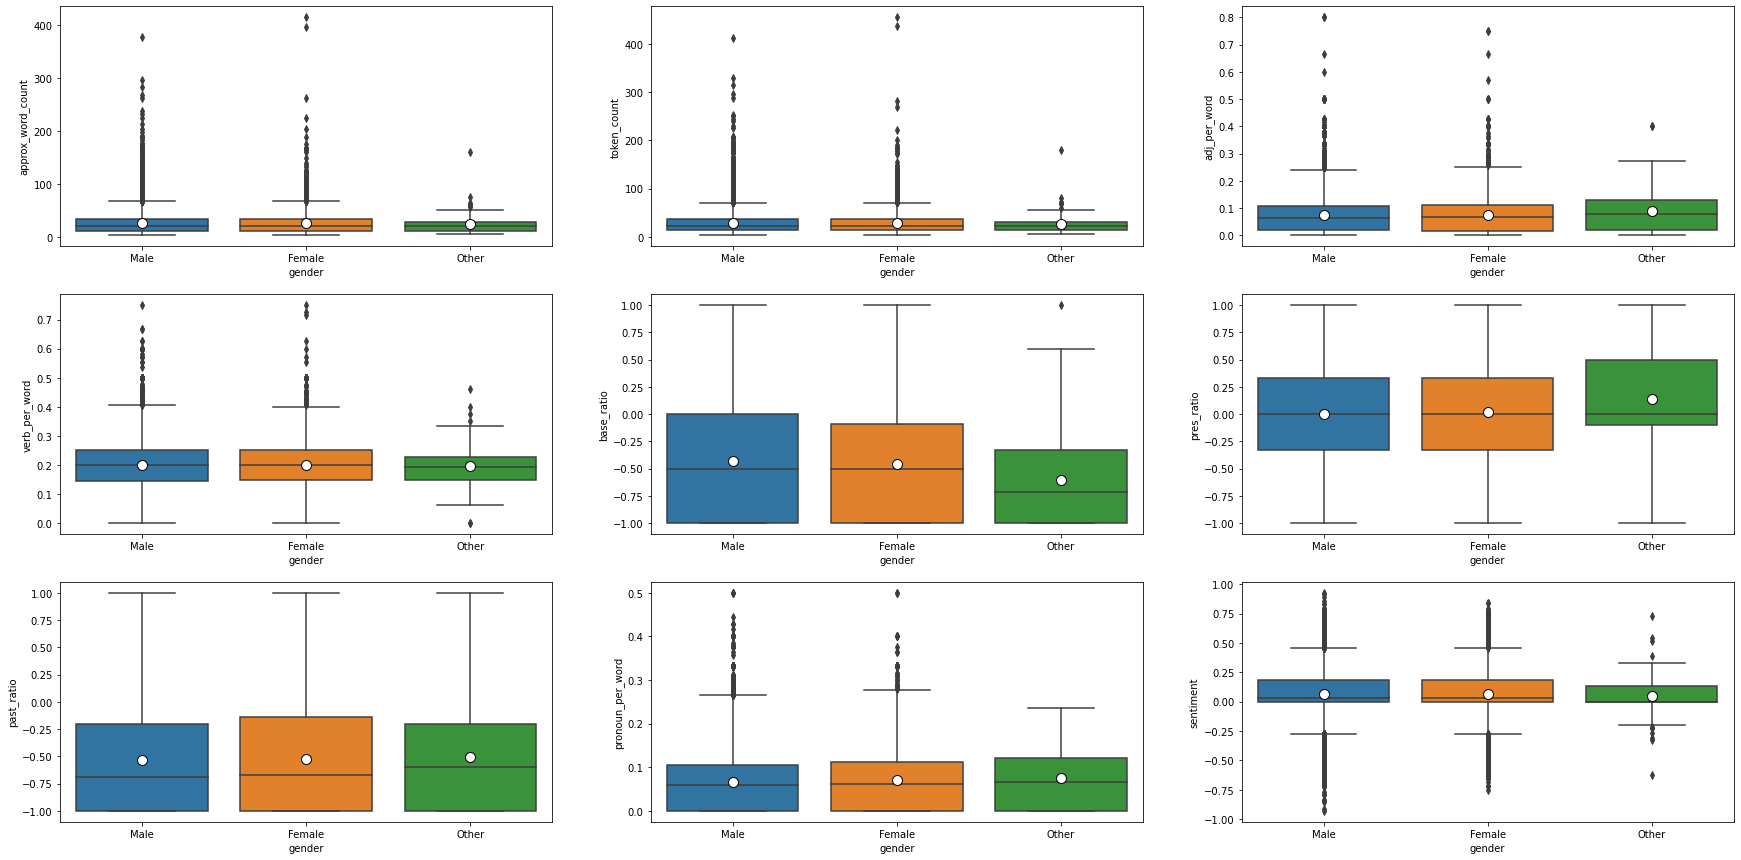

In [142]:
mean_boxplots(sample,plot_by='gender',features=selected_feats)

## Occupation

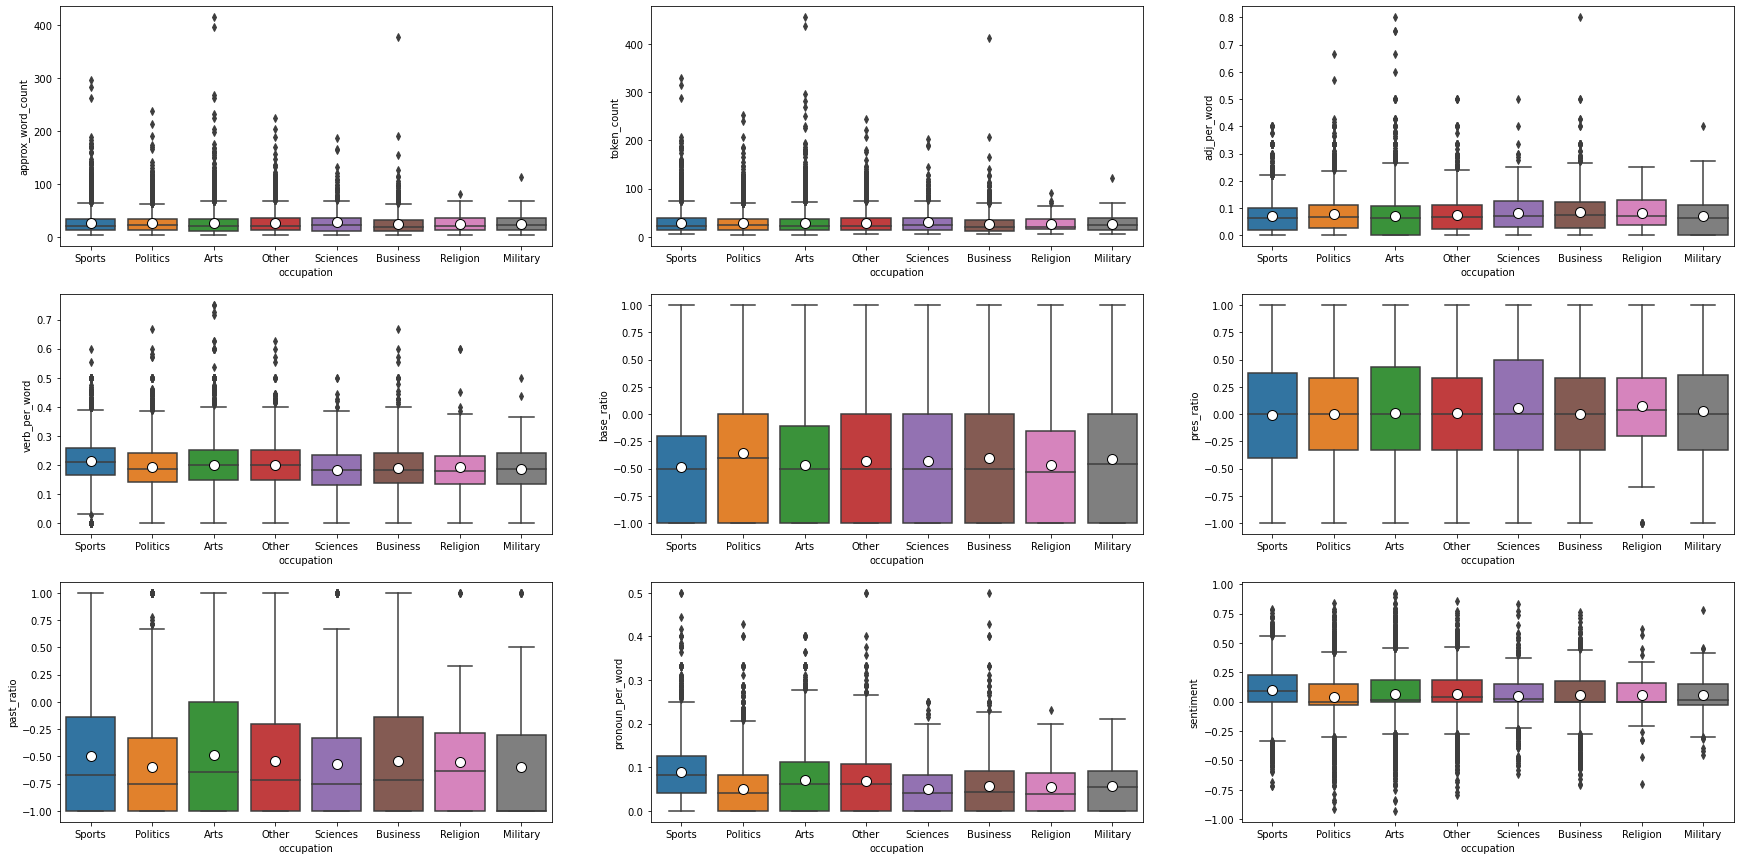

In [143]:
mean_boxplots(sample,plot_by='occupation',features=selected_feats)

## Academic Degree

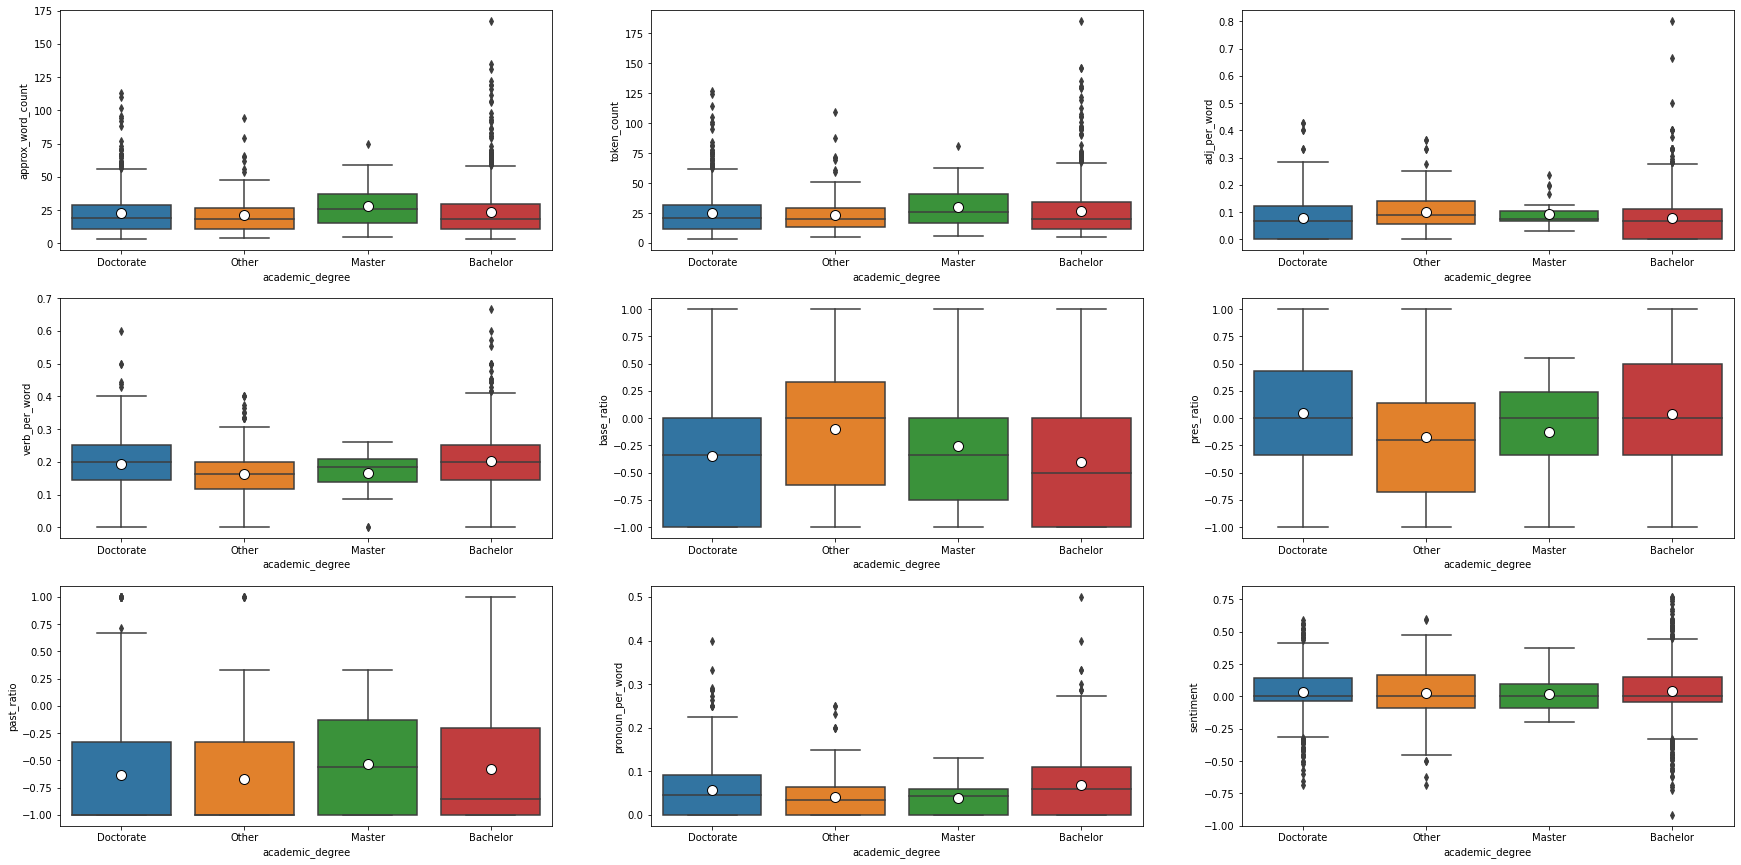

In [144]:
mean_boxplots(sample,plot_by='academic_degree',features=selected_feats)

## Religion

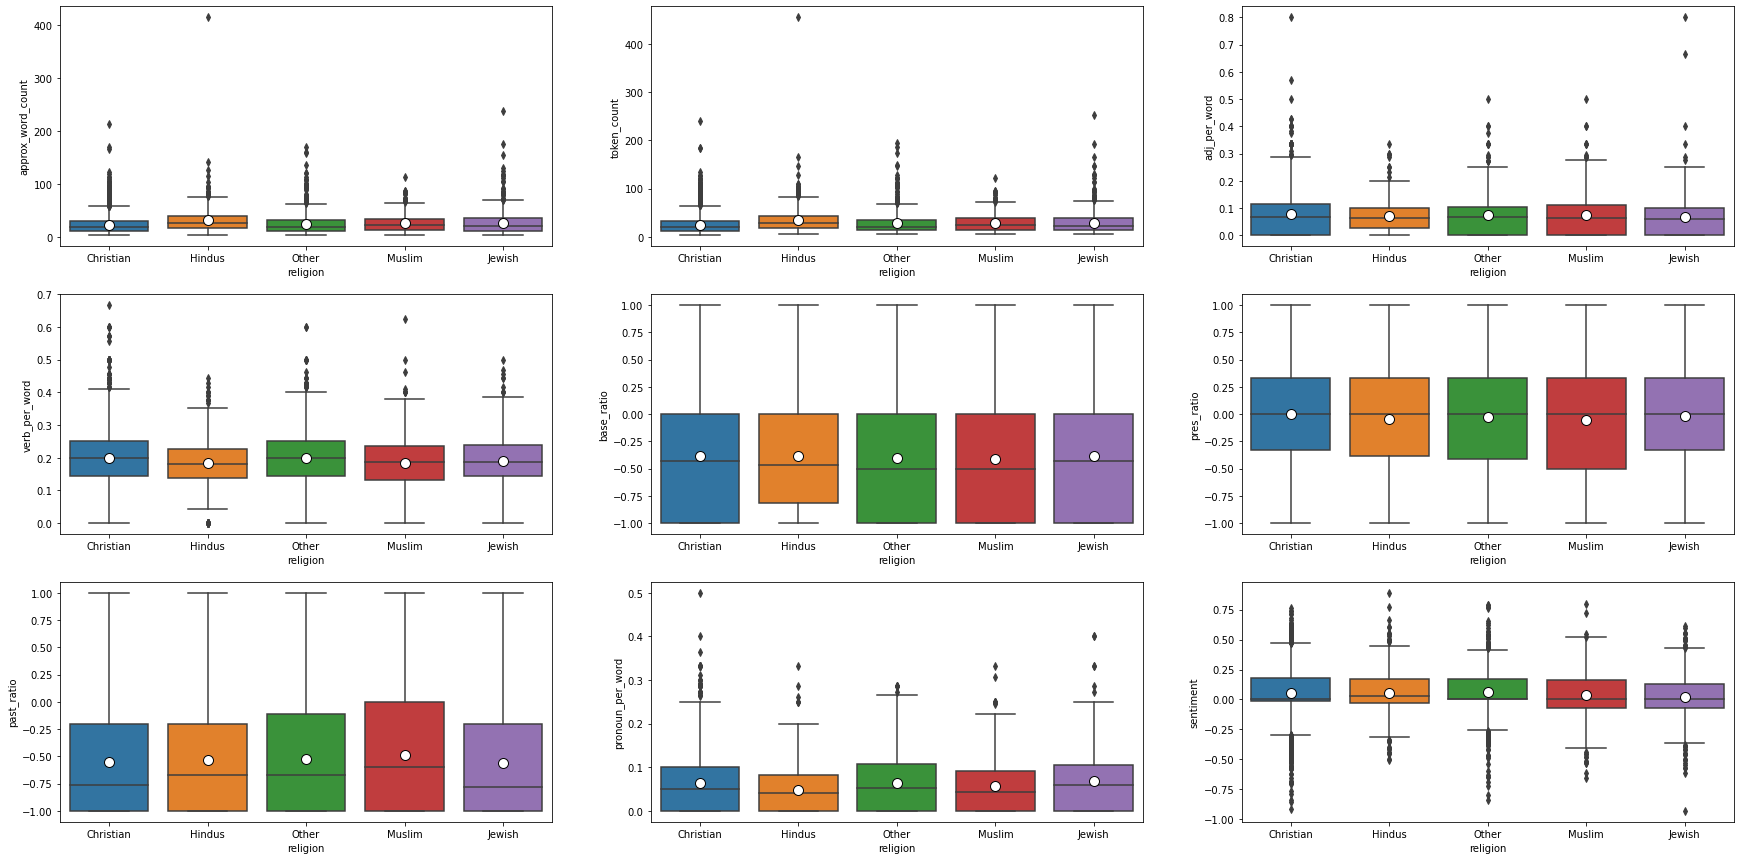

In [145]:
mean_boxplots(sample,plot_by='religion',features=selected_feats)

## Generation

In [146]:
def GroupBirthDates(sample):
    birth = sample.copy()
    birth["date_of_birth"] = birth["date_of_birth"].astype(int)
    birth["date_of_birth"] = birth["date_of_birth"].apply(lambda x: '30s' if x < 1940 else '50s' if x < 1960 else '70s' if x < 1980  else '90s' if x < 2000 else '00s' if x < 2020 else x)
    return birth

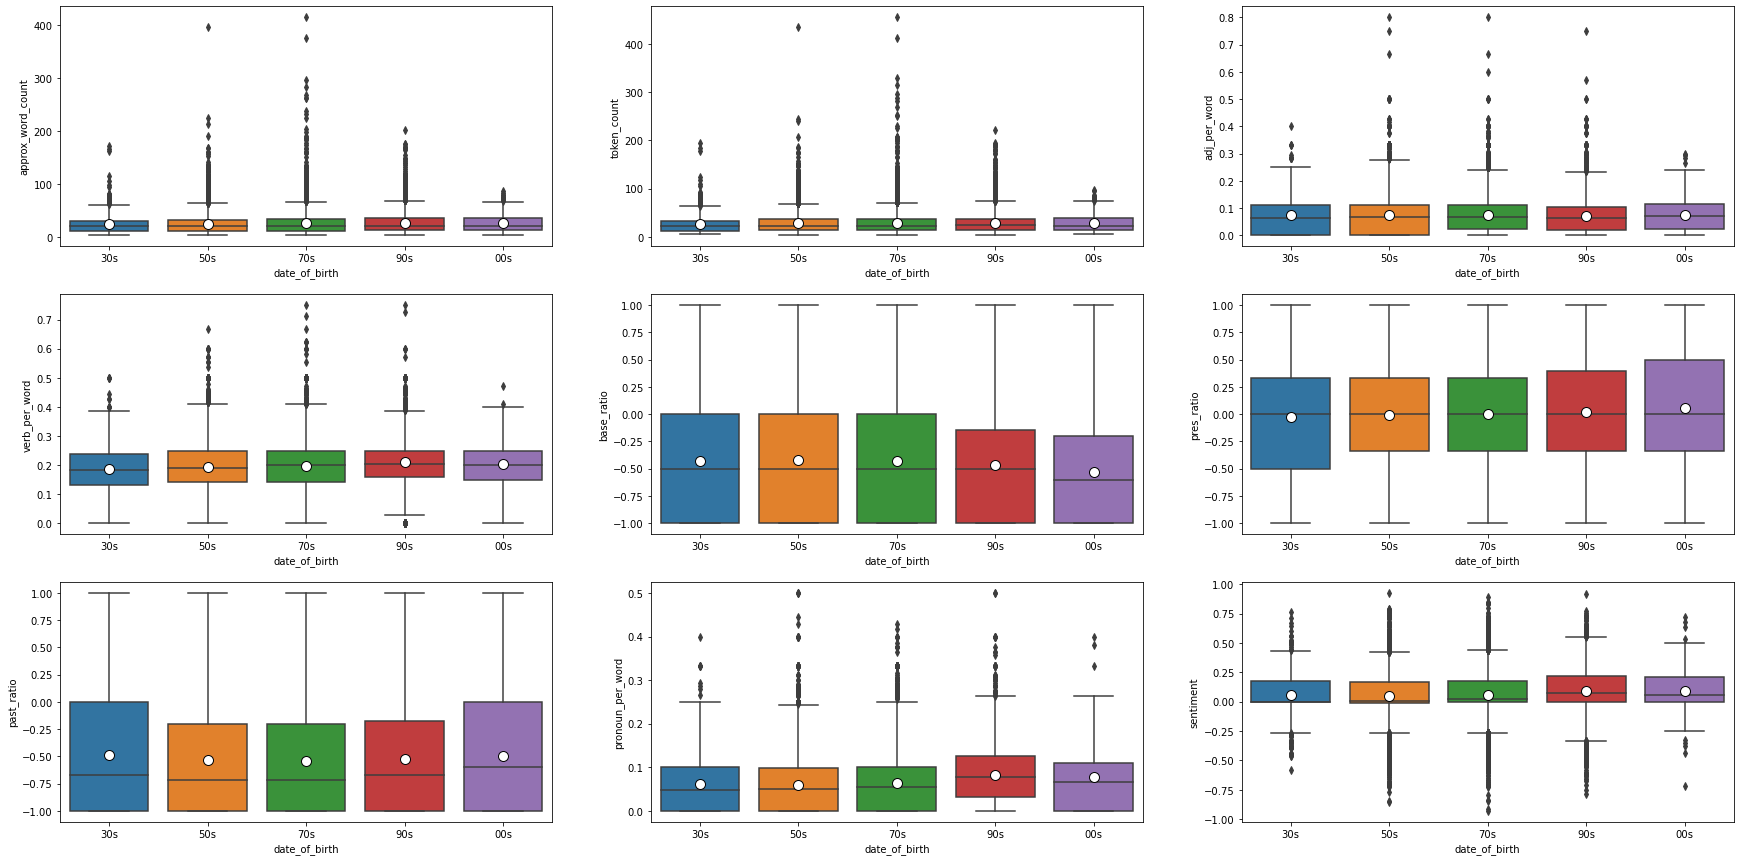

In [147]:
birth = GroupBirthDates(sample)
mean_boxplots(birth,plot_by='date_of_birth',features=selected_feats, order=["30s","50s","70s","90s","00s"])

## Continent

In [148]:
def GroupNationalities(sample):
    nat = sample.copy()
    for idx,i in enumerate(nat["nationality"]):
        try:
            nat["nationality"].iloc[idx] = pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(i, cn_name_format="default"))
        except:
            nat["nationality"].iloc[idx] = None
    return nat

/home/karim/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


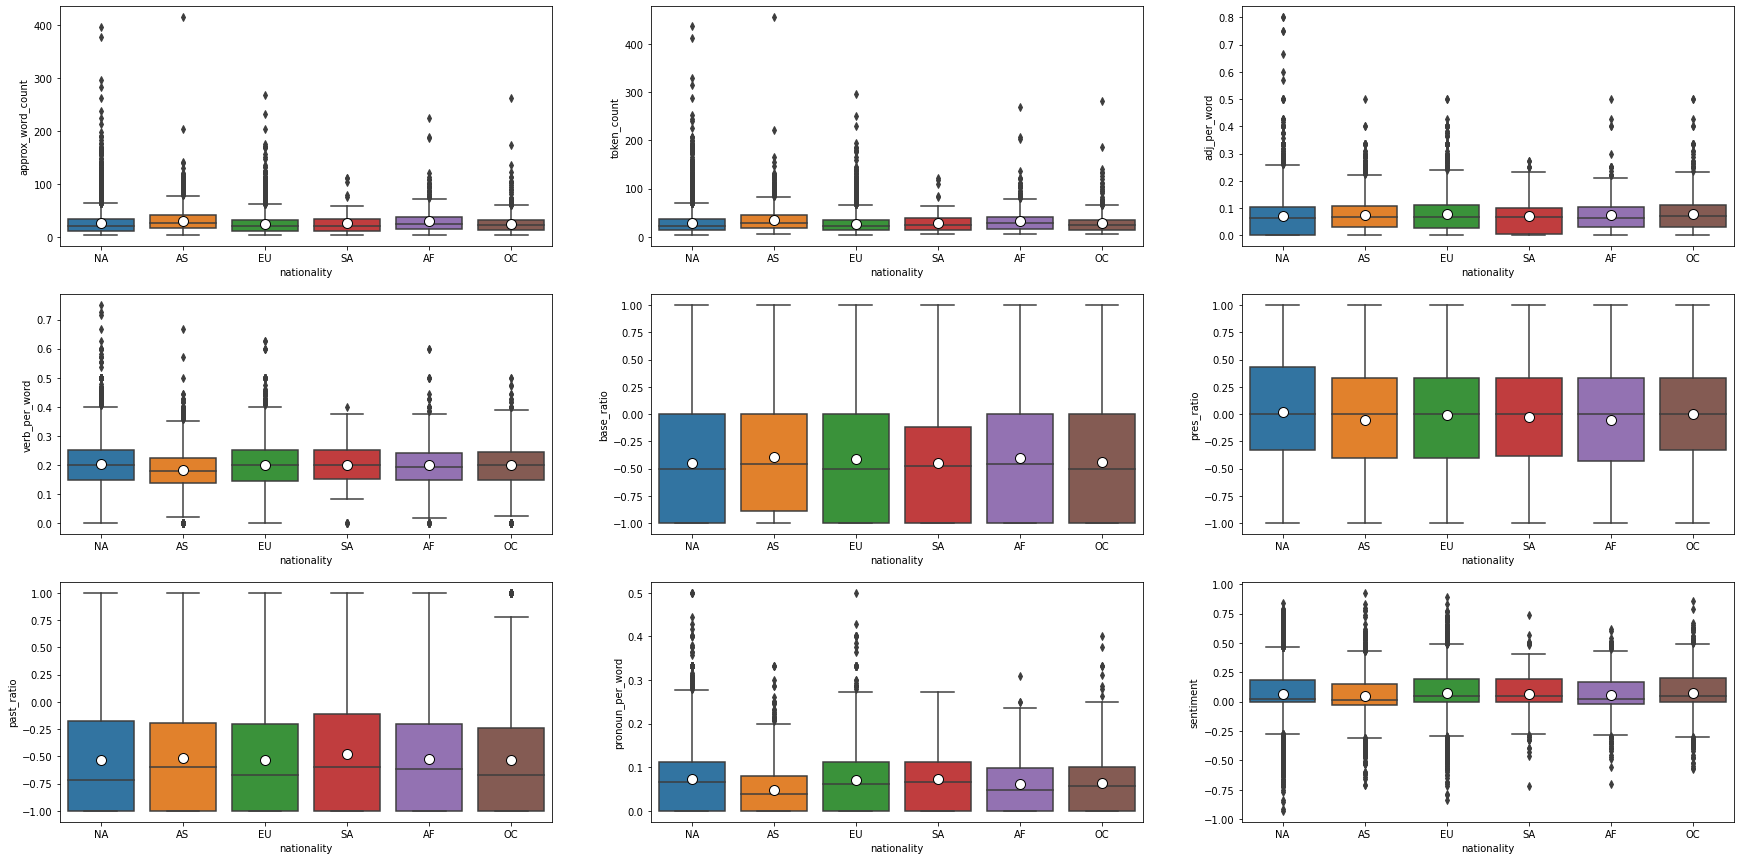

In [149]:
countries = GroupNationalities(sample)
mean_boxplots(countries,plot_by='nationality',features=selected_feats)

## Test the significance of the observed differences

In [171]:
def TestSignificance(df,lexical_features,speaker_features,tresh=0.05, verbose=False):
    Grid_max = np.zeros(shape=(len(lexical_features),len(speaker_features)))
    Grid_mean = np.zeros(shape=(len(lexical_features),len(speaker_features)))
    for idx_i,i in enumerate(speaker_features):                                      #Iterate over
        for idx_j,j in enumerate(lexical_features):                                  #Iterate over
            unique = df[i].unique()                  #Iterate over the different attributes
            unique = unique[unique != np.array(None)]
            unique = np.array(unique, dtype=str)
            unique = unique[unique != 'nan']
            unique = unique[unique != 'Other']
            pairs = list(itertools.combinations(unique,2))
            min_p = 1
            res = []
            for k in pairs:
                try:
                    N, p = mannwhitneyu(df[df[i]==k[0]][j], df[df[i]==k[1]][j])
                    if p < min_p:
                        min_p = p
                        min_x = k[0]
                        min_y = k[1]
                        param = j
                        speak = i
                        Grid_max[idx_j,idx_i] = 1/min_p
                    res.append(p)   
                except:
                    print('Test failed for {},{}'.format(i,j))
            if verbose:
                print('The maximum statistically significant difference with {} in {} is between {} and {}'.format(j,i,k[0],k[1]))
                print('The p-value is {}'.format(min_p))
            Grid_mean[idx_j,idx_i] = 1/median(res)
    return Grid_mean, Grid_max, lexical_features, speaker_features

In [ ]:
Test = sample.copy()
Test["date_of_birth"] = birth["date_of_birth"]
Test["nationality"] = countries["nationality"]
#selected_feats = ['sentence_count', 'approx_word_count','adj_per_word','verb_per_word', 'base_ratio', 'pres_ratio',
#       'past_ratio', 'pronoun_per_word', 'self_ratio', 'union_ratio',
#       'other_ratio', 'sentiment']
selected_feats = ['sentence_count', '._per_sentence', ',_per_sentence', '!_per_sentence',
       '?_per_sentence', ':_per_sentence', ';_per_sentence', 'sign_per_token',
       'punctuation_per_sentence', 'approx_word_count', 'token_count',
       'adj_per_word', 'ordinal_ratio', 'comparative_ratio',
       'superlative_ratio', 'verb_per_word', 'base_ratio', 'pres_ratio',
       'past_ratio', 'pronoun_per_word', 'self_ratio', 'union_ratio',
       'other_ratio', 'sentiment']
speaker_feats = ['date_of_birth','nationality', 'gender', 'occupation', 'academic_degree', 'religion']
Grid_mean, Grid_max, lexical_features, speaker_features = TestSignificance(Test,selected_feats,speaker_feats,verbose=True)

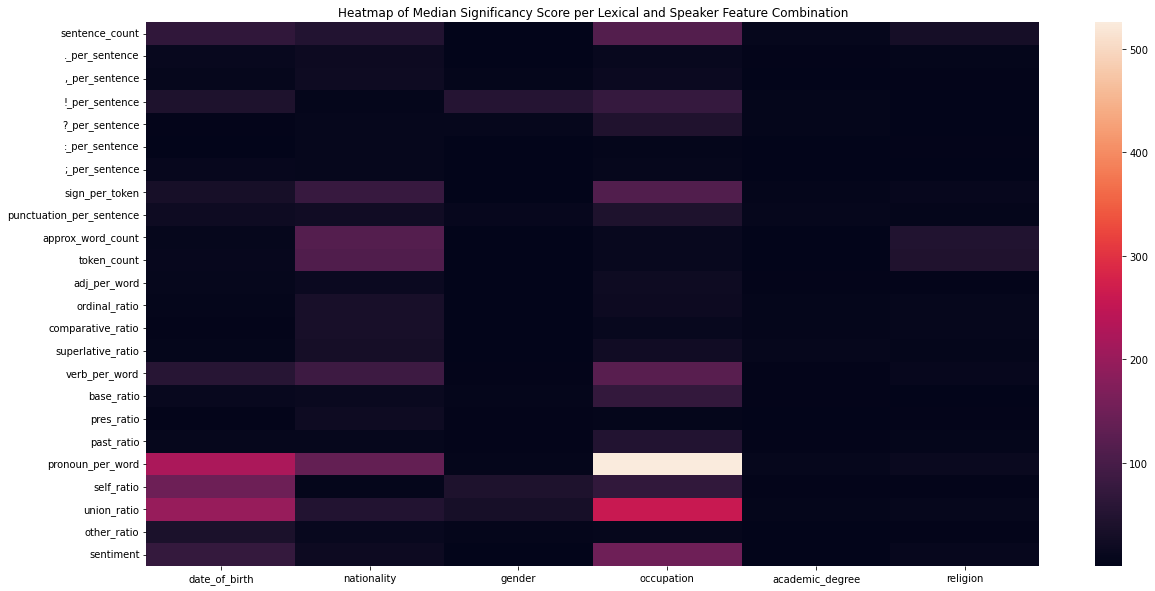

In [181]:
df = pd.DataFrame(data=np.log(Grid_max), index=selected_feats, columns=speaker_feats)
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
plt.title("Heatmap of Median Significancy Score per Lexical and Speaker Feature Combination")
sns.heatmap(df, ax=ax)
plt.show()

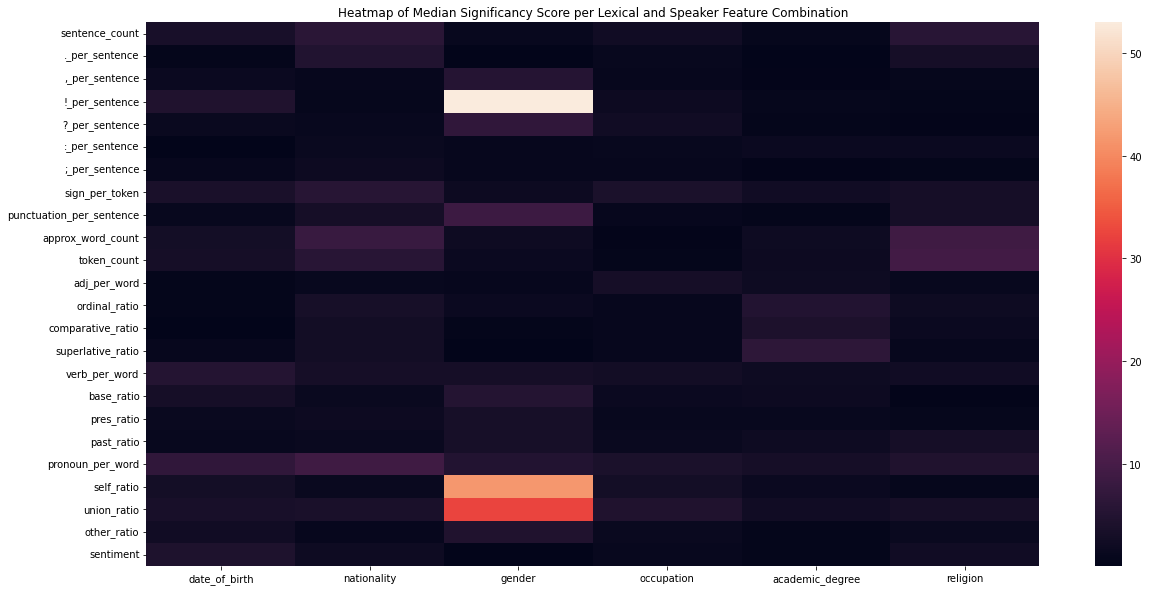

In [180]:
df = pd.DataFrame(data=np.log(Grid_mean), index=selected_feats, columns=speaker_feats)
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(df, ax=ax)
plt.title("Heatmap of Median Significancy Score per Lexical and Speaker Feature Combination")
plt.show()